In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb

from IPython.core.pylabtools import figsize
figsize(12, 8)

url = 'training_data_VT2026.csv'
bikes = pd.read_csv(url, na_values='?', dtype={'ID': str}).dropna()

In [3]:
#np.random.seed(0)

trainI = np.random.choice(bikes.shape[0], size=800, replace=False)
trainIndex = bikes.index.isin(trainI)
train = bikes.iloc[trainIndex]
test = bikes.iloc[~trainIndex]

In [4]:
#model_parameters = ['temp', 'humidity', 'hour_of_day', 'summertime']
features = [
    "hour_of_day","day_of_week","month",
    "holiday","weekday","summertime",
    "temp","dew","humidity",
    "precip","snow","snowdepth",
    "windspeed","cloudcover","visibility"
]
X_train = train[features]
Y_train = np.where(train['increase_stock'] == 'high_bike_demand', 1, 0)
X_test = test[features]
Y_test = np.where(test['increase_stock'] == 'high_bike_demand', 1, 0)


# Pipeline = scaling + KNN
model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=15))
])

model.fit(X_train, Y_train)

predictions = model.predict(X_test)
print('Confusion matrix:\n')
print(pd.crosstab(predictions, Y_test, rownames=['Predicted'], colnames=['Actual']))

#print(train[model_parameters].head())

Confusion matrix:

Actual       0   1
Predicted         
0          615  91
1           37  57


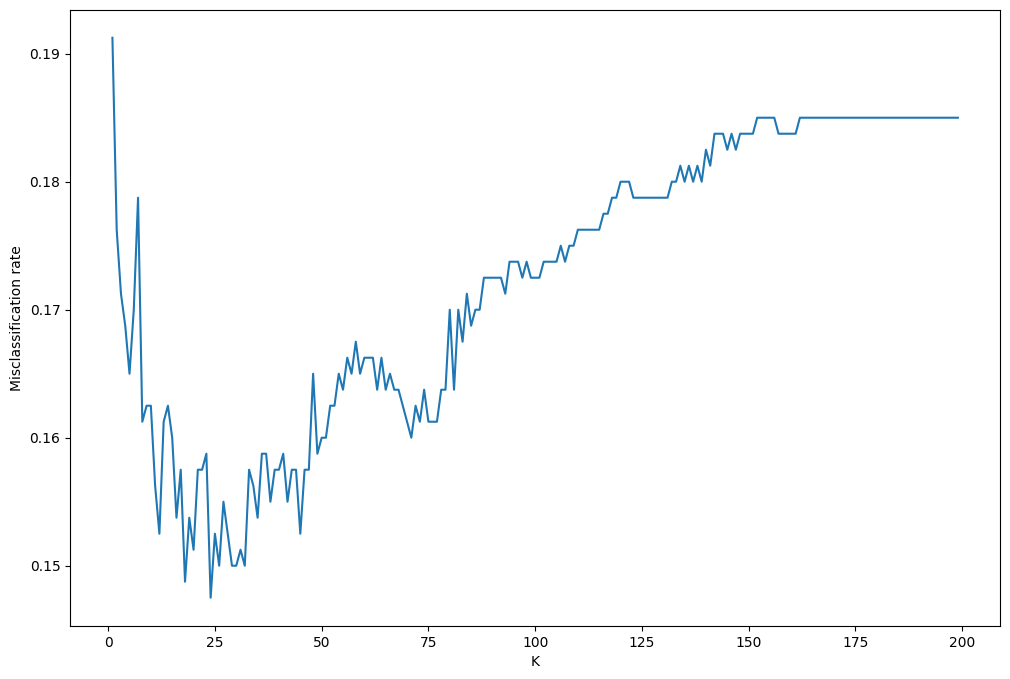

In [5]:
misclassification = []
N = 200
for k in range(1, N):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    misclassification.append(np.mean(predictions != Y_test))

K = np.linspace(1, N-1, N-1)
plt.plot(K, misclassification)
plt.xlabel('K')
plt.ylabel('Misclassification rate')
plt.show()

In [6]:
print(pd.Series(Y_train).value_counts(normalize=True))
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

0    0.825
1    0.175
Name: proportion, dtype: float64
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       652
           1       0.00      0.00      0.00       148

    accuracy                           0.81       800
   macro avg       0.41      0.50      0.45       800
weighted avg       0.66      0.81      0.73       800



/home/henrik/Documents/Plugg/Statistisk Maskininlärning/Smaskprojekt/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/henrik/Documents/Plugg/Statistisk Maskininlärning/Smaskprojekt/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/henrik/Documents/Plugg/Statistisk Maskininlärning/Smaskprojekt/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with 

Naiv knn väldigt dålig, gör ett antal förbättringar:
scaling, SMOTE oversampling (class imbalance), ANOVA F-test (select non noisy features), GridSearchCV tuning, Distance weighting

In [7]:
features = [
    "hour_of_day", "summertime",
    "temp", "humidity"
]
X_train = train[features]
Y_train = np.where(train['increase_stock'] == 'high_bike_demand', 1, 0)
X_test = test[features]
Y_test = np.where(test['increase_stock'] == 'high_bike_demand', 1, 0)


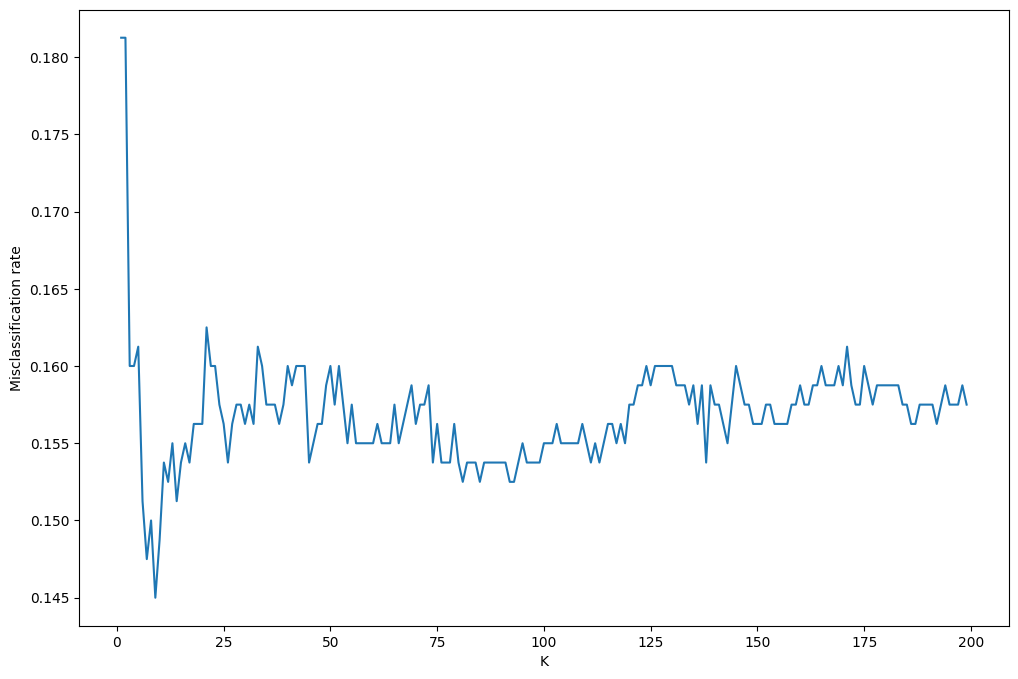

Confusion matrix:

Actual       0    1
Predicted          
0          629  103
1           23   45


In [14]:
misclassification = []
N = 200
for k in range(1, N):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean'))
    ])
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    misclassification.append(np.mean(predictions != Y_test))

K = np.linspace(1, N-1, N-1)
plt.plot(K, misclassification)
plt.xlabel('K')
plt.ylabel('Misclassification rate')
plt.show()

print('Confusion matrix:\n')
print(pd.crosstab(predictions, Y_test, rownames=['Predicted'], colnames=['Actual']))


Viktat på avstånd ger att höga k ej längre suger balle, fortfarande jättemånga sant negativa pga 80% nollor -> oversampling

In [32]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

model = Pipeline([
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=20))
])

model.fit(X_train, Y_train)

predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))
print('Confusion matrix:\n')
print(pd.crosstab(predictions, Y_test, rownames=['Predicted'], colnames=['Actual']))


              precision    recall  f1-score   support

           0       0.95      0.81      0.87       652
           1       0.49      0.82      0.61       148

    accuracy                           0.81       800
   macro avg       0.72      0.81      0.74       800
weighted avg       0.87      0.81      0.82       800

Confusion matrix:

Actual       0    1
Predicted          
0          526   27
1          126  121


Mer balanserat från 45% till 75% recall för high demand